# Convolutional Neural Networks

## Project: Write an Algorithm for Landmark Classification

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. 

You will not need to modify the included code beyond what is requested. 

Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. 

Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all the code implementations, you need to finalize your work by exporting the Jupyter Notebook as an **HTML document**. 
> 
> Before exporting the notebook to HTML, all the code cells need to have been run so that reviewers can see the final implementation and output. 
> 
> You can then export the notebook by using the menu above and navigating to **File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this Jupyter notebook.

---

### Why We're Here

Photo sharing and photo storage services like to have location data for each photo that is uploaded. With the location data, these services can build advanced features, such as automatic suggestion of relevant tags or automatic photo organization, which help provide a compelling user experience. Although a photo's location can often be obtained by looking at the photo's metadata, many photos uploaded to these services will not have location metadata available. This can happen when, for example, the camera capturing the picture does not have GPS or if a photo's metadata is scrubbed due to privacy concerns.

If no location metadata for an image is available, one way to infer the location is to detect and classify a discernible landmark in the image. Given the large number of landmarks across the world and the immense volume of images that are uploaded to photo sharing services, using human judgement to classify these landmarks would not be feasible.

In this notebook, you will take the first steps towards addressing this problem by building models to automatically predict the location of the image based on any landmarks depicted in the image. At the end of this project, your code will accept any user-supplied image as input and suggest the top k most relevant landmarks from 50 possible landmarks from across the world. The image below displays a potential sample output of your finished project.

![Sample landmark classification output](images/sample_landmark_output.png)

--- 

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Download Datasets and Install Python Modules
* [Step 1](#step1): Create a CNN to Classify Landmarks (from Scratch)
* [Step 2](#step2): Create a CNN to Classify Landmarks (using Transfer Learning)
* [Step 3](#step3): Write Your Landmark Prediction Algorithm

---
<a id='step0'></a>
## Step 0: Download Datasets and Install Python Modules

**Note: if you are using the Udacity workspace, *YOU CAN SKIP THIS STEP*. The dataset can be found in the `/data` folder and all required Python modules have been installed in the workspace.**

Download the [landmark dataset](https://udacity-dlnfd.s3-us-west-1.amazonaws.com/datasets/landmark_images.zip).
Unzip the folder and place it in this project's home directory, at the location `/landmark_images`.

Install the following Python modules:
* cv2
* matplotlib
* numpy
* PIL
* torch
* torchvision

In [1]:
import os 
import numpy as np 
import torch 
import torch.nn as nn
import torch.nn.functional as F 
import torch.optim as optim 

import torchvision 
from torchvision import datasets, models, transforms 
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt 


---

<a id='step1'></a>
## Step 1: Create a CNN to Classify Landmarks (from Scratch)

In this step, you will create a CNN that classifies landmarks.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 20%.

Although 20% may seem low at first glance, it seems more reasonable after realizing how difficult of a problem this is. Many times, an image that is taken at a landmark captures a fairly mundane image of an animal or plant, like in the following picture.

<img src="images/train/00.Haleakala_National_Park/084c2aa50d0a9249.jpg" alt="Bird in Haleakalā National Park" style="width: 400px;"/>

Just by looking at that image alone, would you have been able to guess that it was taken at the Haleakalā National Park in Hawaii?

An accuracy of 20% is significantly better than random guessing, which would provide an accuracy of just 2%. In Step 2 of this notebook, you will have the opportunity to greatly improve accuracy by using transfer learning to create a CNN.

Remember that practice is far ahead of theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

### (IMPLEMENTATION) Specify Data Loaders for the Landmark Dataset

Use the code cell below to create three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader): one for training data, one for validation data, and one for test data. Randomly split the images located at `landmark_images/train` to create the train and validation data loaders, and use the images located at `landmark_images/test` to create the test data loader.

All three of your data loaders should be accessible via a dictionary named `loaders_scratch`. Your train data loader should be at `loaders_scratch['train']`, your validation data loader should be at `loaders_scratch['valid']`, and your test data loader should be at `loaders_scratch['test']`.

You may find [this documentation on custom datasets](https://pytorch.org/docs/stable/torchvision/datasets.html#datasetfolder) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [2]:
### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes

# [+] get train & test data 

# [-] dict of loaders 
loaders_scratch = {'train': None, 'valid': None, 'test': None}

# [-] training and test data dir 
data_dir  = 'landmark_images'
train_dir = os.path.join(data_dir, 'train/')
test_dir  = os.path.join(data_dir, 'test/')

# [-] data transform
data_transform = transforms.Compose([
    # transforms.RandomRotation(10),      # [.] random rotate    
    transforms.Resize(32),              # [.] resize
    transforms.CenterCrop(32),          # [.] center crop 
    # transforms.RandomHorizontalFlip(),  # [.] random flip 
    transforms.ToTensor(),              # [.] convert to tensor 
    transforms.Normalize(               # [.] normalize RGB values 
        (0.5, 0.5, 0.5), 
        (0.5, 0.5, 0.5) 
    ), 
])

# [-] train and test data 
train_data = datasets.ImageFolder( # [.] train data 
    train_dir, 
    transform=data_transform, 
)

test_data = datasets.ImageFolder( # [.] test data 
    test_dir, 
    transform=data_transform, 
)

print('num of train images:\t', len(train_data))
print('num of test images:\t', len(test_data))


num of train images:	 4996
num of test images:	 1250


In [3]:
# get the shape of the 1st 10 examples in [C, H, W]
for i in range(10):
    print('shape of example ', i, ': ', train_data[i][0].shape) 

shape of example  0 :  torch.Size([3, 32, 32])
shape of example  1 :  torch.Size([3, 32, 32])
shape of example  2 :  torch.Size([3, 32, 32])
shape of example  3 :  torch.Size([3, 32, 32])
shape of example  4 :  torch.Size([3, 32, 32])
shape of example  5 :  torch.Size([3, 32, 32])
shape of example  6 :  torch.Size([3, 32, 32])
shape of example  7 :  torch.Size([3, 32, 32])
shape of example  8 :  torch.Size([3, 32, 32])
shape of example  9 :  torch.Size([3, 32, 32])


In [4]:
# w_list = []

# for i in range(len(train_data)):
#     w = train_data[i][0].shape[1]
#     w_list.append(w)

# h_list = []

# for i in range(len(train_data)):
#     h = train_data[i][0].shape[2]
#     h_list.append(h)

# # image height range before transform: 225 - 800
# print('min image height:', min(h_list))
# print('max image height:', max(h_list))

# # image width range before applying transform: 60 - 800
# print('min image width:', min(w_list))
# print('max image width:', max(w_list))


In [5]:
# [+] create dataloader 

# [-] data loader params 
num_workers = 0     # [.] num of subprocesses for data loading
batch_size  = 50    # [.] num of samples per batch to load
valid_ratio = 0.2   # [.] % of train data to be used for validation

# [-] get train indices for validation
num_train     = len(train_data)
train_indices = list(range(num_train))
np.random.shuffle(train_indices)
split = int(np.floor(valid_ratio * num_train))
train_idx = train_indices[split:]
valid_idx = train_indices[:split]

## print out some data stats
print('Num training images: ',   len(train_idx))
print('Num validation images: ', len(valid_idx))
print('Num test images: ',       len(test_data))

# [-] samplers to get training and validation batches 
# note that sampler & shuffle are mutually exclusive
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# [-] data loaders 
train_loader = torch.utils.data.DataLoader( # [.] train loader 
    train_data, 
    batch_size  = batch_size,
    sampler     = train_sampler,
    num_workers = num_workers,
    # shuffle     = True,   # shuffle & sampler are mutually exclusive
)

valid_loader = torch.utils.data.DataLoader( # [.] valid loader 
    train_data, 
    batch_size  = batch_size,
    sampler     = valid_sampler,
    num_workers = num_workers,
    # shuffle     = True,   # shuffle & sampler are mutually exclusive
)

test_loader = torch.utils.data.DataLoader( # [.] test loader 
    test_data, 
    batch_size  = batch_size,
    num_workers = num_workers,
    shuffle     = True,
)

# [-] assign loders to loader dict 
loaders_scratch = {
    'train': train_loader, 
    'valid': valid_loader, 
    'test': test_loader
}

Num training images:  3997
Num validation images:  999
Num test images:  1250


**Question 1:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?

**Answer**: 

- used RandomRotation(10), Resize([32, 32]), RandomHorizontalFlip()

### (IMPLEMENTATION) Visualize a Batch of Training Data

Use the code cell below to retrieve a batch of images from your train data loader, display at least 5 images simultaneously, and label each displayed image with its class name (e.g., "Golden Gate Bridge").

Visualizing the output of your data loader is a great way to ensure that your data loading and preprocessing are working as expected.

<ipython-input-6-eece1c8f1cda>:26: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = fig.add_subplot(


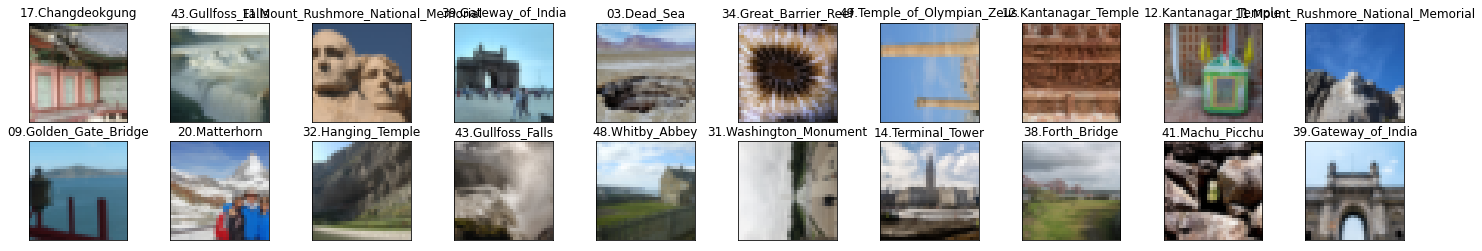

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

## TODO: visualize a batch of the train data loader

## the class names can be accessed at the `classes` attribute
## of your dataset object (e.g., `train_dataset.classes`)

# [+] print example from one batch 

# [-] get a list of class names 
classes = train_data.classes 

# [-] get one batch of train images 
dataiter = iter(train_loader)       # [.] convert dataloader to an iterator 
images, labels = dataiter.next()    # [.] get one batch data from iterator
images = images.numpy()             # [.] convert image tensor to numpy array 

# [-] plot images with label
num_img = 20    # num of images to show 
num_rows = 2    # num of rows 

fig = plt.figure(figsize=(25, 4))

for idx in np.arange(num_img):
    ax = fig.add_subplot(
        num_rows,
        num_img/num_rows, 
        idx+1, 
        xticks=[], 
        yticks=[], 
    )
    # [.] unnormalize image data 
    img = images[idx] / 2 + 0.5     
    # [.] convert from PyTorch Tensor image type (0=C, 1=H, 2=W) to Numpy image type (0=H, 1=W, 2=C)
    plt.imshow(np.transpose(img, (1, 2, 0))) 
    # [.] print text label for each image 
    ax.set_title(classes[labels[idx]])


### Initialize use_cuda variable

In [7]:
# useful variable that tells us whether we should use the GPU
use_cuda = torch.cuda.is_available()

if not use_cuda:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')


CUDA is not available.  Training on CPU ...


### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and fill in the function `get_optimizer_scratch` below.

In [8]:
## TODO: select loss function
criterion_scratch = nn.CrossEntropyLoss()

def get_optimizer_scratch(model):
    ## TODO: select and return an optimizer
    
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    return optimizer 
    

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify images of landmarks.  Use the template in the code cell below.

In [9]:
import torch.nn as nn

# define the CNN architecture
class Net(nn.Module):
    ## TODO: choose an architecture, and complete the class
    def __init__(self):
        super(Net, self).__init__()
        
        ## Define layers of a CNN
        self.conv1 = nn.Conv2d(     # [.] Conv1, in=3x32x32, out=16x16x16
            in_channels  = 3,
            out_channels = 16,
            kernel_size  = 3,
            # stride       = 2,
            padding      = 1,
        )
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)     # [.] conv2, out: 32x8x8
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)     # [.] conv3, out: 64x4x4
        self.maxpool = nn.MaxPool2d(2, 2)           # [.] maxpool for downsampling 32 -> 16 -> 8 
        self.fc1 = nn.Linear(64*4*4, 500)           # [.] fc1, flattern the output of maxpool, in: 64x4x4, out: 500
        self.fc2 = nn.Linear(500, 50)               # [.] fc2, in: 500, out: 50 (there are 50 classes in this dataset)
        self.dropout = nn.Dropout(0.25)             # [.] dropout by 25%    
                
    def forward(self, x):
        ## Define forward behavior
        out1 = self.maxpool(F.relu(self.conv1(x)))      
        out2 = self.maxpool(F.relu(self.conv2(out1)))
        out3 = self.maxpool(F.relu(self.conv3(out2)))
        out3_flattened = out3.view(-1, 64*4*4)      # flatten image
        out4 = self.dropout(out3_flattened)         # add dropout
        out5 = F.relu(self.fc1(out4))               # add fully connected layers
        out6 = self.dropout(out5)                   # add dropout
        out_final = self.fc2(out6)      
        
        return out_final

#-#-# Do NOT modify the code below this line. #-#-#

# instantiate the CNN
model_scratch = Net()
print(model_scratch)

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()


Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=50, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)


__Question 2:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

__Answer:__  

- Use a few conv2d layers to increase the number of feature maps incrementally, but reduce their size gradually. 

- Apply fully connected layer to reduce the number of output to that of the number of classes. 

- Apply dropout to reduce overfitting. 

### (IMPLEMENTATION) Implement the Training Algorithm

Implement your training algorithm in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at the filepath stored in the variable `save_path`.

In [10]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        # set the module to training mode
        model.train()
        
        # interate the batches 
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            ## TODO: find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - train_loss))
            optimizer.zero_grad()               # clear gradients of all optimized params
            output = model(data)                # forward pass to get prediction
            loss = criterion(output, target)    # calc batch loss
            loss.backward()                     # backward pass, calc gradients
            optimizer.step()                    # optimize (update params)
            train_loss += ((1 / (batch_idx + 1)) * \
                          (loss.data.item() - train_loss)) # update avg training loss

        ######################    
        # validate the model #
        ######################
        # set the model to evaluation mode
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            ## TODO: update average validation loss 
            output = model(data)                # forward pass, calc prediction
            loss = criterion(output, target)    # calc batch loss
            valid_loss += ((1 / (batch_idx + 1)) * \
                          (loss.data.item() - valid_loss)) # update avg valis

        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'
              .format(epoch, train_loss, valid_loss)
             )

        ## TODO: if the validation loss has decreased, save the model at the filepath stored in save_path
        if valid_loss <= valid_loss_min: 
            print(
                'Validation loss decreased ({:.6f} -> {:.6f}). Saving model ....'
                .format(valid_loss, valid_loss_min)
            )
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss
            
    return model


### (IMPLEMENTATION) Experiment with the Weight Initialization

Use the code cell below to define a custom weight initialization, and then train with your weight initialization for a few epochs. Make sure that neither the training loss nor validation loss is `nan`.

Later on, you will be able to see how this compares to training with PyTorch's default weight initialization.

In [11]:
def custom_weight_init(m):
    ## TODO: implement a weight initialization strategy
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        # apply a uniform distribution to weights, set bias = 0
        m.weight.data.uniform_(0.0, 1.0)
        m.bias.data.fill_(0)

#-#-# Do NOT modify the code below this line. #-#-#
    
model_scratch.apply(custom_weight_init)
model_scratch = train(
    5, 
    loaders_scratch, 
    model_scratch, 
    get_optimizer_scratch(model_scratch),
    criterion_scratch, 
    use_cuda, 
    'ignore.pt'
)


/Users/minioat/opt/anaconda3/envs/udacity-deep-learning/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /tmp/pip-req-build-accccgfm/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch: 1 	Training Loss: 17.428818 	Validation Loss: 3.914156
Validation loss decreased (3.914156 -> inf). Saving model ....
Epoch: 2 	Training Loss: 3.917169 	Validation Loss: 3.915450
Epoch: 3 	Training Loss: 3.914500 	Validation Loss: 3.915994
Epoch: 4 	Training Loss: 3.913311 	Validation Loss: 3.915941
Epoch: 5 	Training Loss: 3.912946 	Validation Loss: 3.916121


### (IMPLEMENTATION) Train and Validate the Model

Run the next code cell to train your model.

In [12]:
## TODO: you may change the number of epochs if you'd like,
## but changing it is not required
num_epochs = 10

#-#-# Do NOT modify the code below this line. #-#-#

# function to re-initialize a model with pytorch's default weight initialization
def default_weight_init(m):
    reset_parameters = getattr(m, 'reset_parameters', None)
    if callable(reset_parameters):
        m.reset_parameters()

# reset the model parameters
model_scratch.apply(default_weight_init)

# train the model
model_scratch = train(num_epochs, loaders_scratch, model_scratch, get_optimizer_scratch(model_scratch), 
                      criterion_scratch, use_cuda, 'model_scratch.pt')

Epoch: 1 	Training Loss: 3.835095 	Validation Loss: 3.618206
Validation loss decreased (3.618206 -> inf). Saving model ....
Epoch: 2 	Training Loss: 3.544767 	Validation Loss: 3.434610
Validation loss decreased (3.434610 -> 3.618206). Saving model ....
Epoch: 3 	Training Loss: 3.382904 	Validation Loss: 3.431129
Validation loss decreased (3.431129 -> 3.434610). Saving model ....
Epoch: 4 	Training Loss: 3.204540 	Validation Loss: 3.185303
Validation loss decreased (3.185303 -> 3.431129). Saving model ....
Epoch: 5 	Training Loss: 3.021388 	Validation Loss: 3.098600
Validation loss decreased (3.098600 -> 3.185303). Saving model ....
Epoch: 6 	Training Loss: 2.835203 	Validation Loss: 3.039101
Validation loss decreased (3.039101 -> 3.098600). Saving model ....
Epoch: 7 	Training Loss: 2.679696 	Validation Loss: 3.019703
Validation loss decreased (3.019703 -> 3.039101). Saving model ....
Epoch: 8 	Training Loss: 2.522266 	Validation Loss: 2.923920
Validation loss decreased (2.923920 -> 3.

### (IMPLEMENTATION) Test the Model

Run the code cell below to try out your model on the test dataset of landmark images. Run the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 20%.

In [13]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    # set the module to evaluation mode
    model.eval()

    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 2.930595


Test Accuracy: 26% (333/1250)


---
<a id='step2'></a>
## Step 2: Create a CNN to Classify Landmarks (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify landmarks from images.  Your CNN must attain at least 60% accuracy on the test set.

### (IMPLEMENTATION) Specify Data Loaders for the Landmark Dataset

Use the code cell below to create three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader): one for training data, one for validation data, and one for test data. Randomly split the images located at `landmark_images/train` to create the train and validation data loaders, and use the images located at `landmark_images/test` to create the test data loader.

All three of your data loaders should be accessible via a dictionary named `loaders_transfer`. Your train data loader should be at `loaders_transfer['train']`, your validation data loader should be at `loaders_transfer['valid']`, and your test data loader should be at `loaders_transfer['test']`.

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

In [14]:
### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes

loaders_transfer = {'train': None, 'valid': None, 'test': None}

# [-] training and test data dir 
data_dir  = 'landmark_images'
train_dir = os.path.join(data_dir, 'train/')
test_dir  = os.path.join(data_dir, 'test/')

# [-] data transform
data_transform = transforms.Compose([
    # transforms.RandomRotation(10),      # [.] random rotate    
    transforms.Resize(32),              # [.] resize
    transforms.CenterCrop(32),          # [.] center crop 
    # transforms.RandomHorizontalFlip(),  # [.] random flip 
    transforms.ToTensor(),              # [.] convert to tensor 
    transforms.Normalize(               # [.] normalize RGB values 
        (0.5, 0.5, 0.5), 
        (0.5, 0.5, 0.5) 
    ), 
])

# [-] train and test data 
train_data = datasets.ImageFolder( # [.] train data 
    train_dir, 
    transform=data_transform, 
)

test_data = datasets.ImageFolder( # [.] test data 
    test_dir, 
    transform=data_transform, 
)

print('num of train images:\t', len(train_data))
print('num of test images:\t', len(test_data))


num of train images:	 4996
num of test images:	 1250


In [15]:
# [+] create dataloader 

# [-] data loader params 
num_workers = 0     # [.] num of subprocesses for data loading
batch_size  = 50    # [.] num of samples per batch to load
valid_ratio = 0.2   # [.] % of train data to be used for validation

# [-] get train indices for validation
num_train     = len(train_data)
train_indices = list(range(num_train))
np.random.shuffle(train_indices)
split = int(np.floor(valid_ratio * num_train))
train_idx = train_indices[split:]
valid_idx = train_indices[:split]

## print out some data stats
print('Num training images: ',   len(train_idx))
print('Num validation images: ', len(valid_idx))
print('Num test images: ',       len(test_data))

# [-] samplers to get training and validation batches 
# note that sampler & shuffle are mutually exclusive
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# [-] data loaders 
train_loader = torch.utils.data.DataLoader( # [.] train loader 
    train_data, 
    batch_size  = batch_size,
    sampler     = train_sampler,
    num_workers = num_workers,
    # shuffle     = True,   # shuffle & sampler are mutually exclusive
)

valid_loader = torch.utils.data.DataLoader( # [.] valid loader 
    train_data, 
    batch_size  = batch_size,
    sampler     = valid_sampler,
    num_workers = num_workers,
    # shuffle     = True,   # shuffle & sampler are mutually exclusive
)

test_loader = torch.utils.data.DataLoader( # [.] test loader 
    test_data, 
    batch_size  = batch_size,
    num_workers = num_workers,
    shuffle     = True,
)

# [-] assign loders to loader dict 
loaders_transfer = {
    'train': train_loader, 
    'valid': valid_loader, 
    'test': test_loader
}

Num training images:  3997
Num validation images:  999
Num test images:  1250


### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_transfer`, and fill in the function `get_optimizer_transfer` below.

In [16]:
## TODO: select loss function
criterion_transfer = nn.CrossEntropyLoss()

def get_optimizer_transfer(model):
    ## TODO: select and return optimizer
    optimizer = optim.SGD(model.classifier.parameters(), lr=0.001)

    return optimizer
    

### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify images of landmarks.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [17]:
## TODO: Specify model architecture

model_transfer = models.vgg16(pretrained=True)
print(model_transfer)

# modify the last layer to match current num of classes
n_inputs = model_transfer.classifier[6].in_features
last_layer = nn.Linear(n_inputs, len(classes))
model_transfer.classifier[6] = last_layer

#-#-# Do NOT modify the code below this line. #-#-#

if use_cuda:
    model_transfer = model_transfer.cuda()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

__Question 3:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__  

- use pretrained vgg16 network
- first, freeze feature parameters
- modify the last layer, keep num_inputs, change num of classes to match the current one

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [18]:
# TODO: train the model and save the best model parameters at filepath 'model_transfer.pt'
num_epochs = 10

model_scratch = train(
    num_epochs,
    loaders_transfer,
    model_transfer, 
    get_optimizer_transfer(model_transfer), 
    criterion_transfer, 
    use_cuda, 
    'model_transfer.pt'
)

#-#-# Do NOT modify the code below this line. #-#-#

# load the model that got the best validation accuracy
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

Epoch: 1 	Training Loss: 3.981455 	Validation Loss: 3.617054
Validation loss decreased (3.617054 -> inf). Saving model ....
Epoch: 2 	Training Loss: 3.625535 	Validation Loss: 3.377880
Validation loss decreased (3.377880 -> 3.617054). Saving model ....
Epoch: 3 	Training Loss: 3.371226 	Validation Loss: 3.205498
Validation loss decreased (3.205498 -> 3.377880). Saving model ....
Epoch: 4 	Training Loss: 3.186266 	Validation Loss: 3.081095
Validation loss decreased (3.081095 -> 3.205498). Saving model ....
Epoch: 5 	Training Loss: 3.055762 	Validation Loss: 2.982642
Validation loss decreased (2.982642 -> 3.081095). Saving model ....
Epoch: 6 	Training Loss: 2.934899 	Validation Loss: 2.910392
Validation loss decreased (2.910392 -> 2.982642). Saving model ....
Epoch: 7 	Training Loss: 2.834135 	Validation Loss: 2.853154
Validation loss decreased (2.853154 -> 2.910392). Saving model ....
Epoch: 8 	Training Loss: 2.770340 	Validation Loss: 2.806727
Validation loss decreased (2.806727 -> 2.

<All keys matched successfully>

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of landmark images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [19]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 2.627629


Test Accuracy: 34% (427/1250)


---
<a id='step3'></a>
## Step 3: Write Your Landmark Prediction Algorithm

Great job creating your CNN models! Now that you have put in all the hard work of creating accurate classifiers, let's define some functions to make it easy for others to use your classifiers.

### (IMPLEMENTATION) Write Your Algorithm, Part 1

Implement the function `predict_landmarks`, which accepts a file path to an image and an integer k, and then predicts the **top k most likely landmarks**. You are **required** to use your transfer learned CNN from Step 2 to predict the landmarks.

An example of the expected behavior of `predict_landmarks`:
```
>>> predicted_landmarks = predict_landmarks('example_image.jpg', 3)
>>> print(predicted_landmarks)
['Golden Gate Bridge', 'Brooklyn Bridge', 'Sydney Harbour Bridge']
```

In [ ]:
import cv2
from PIL import Image

## the class names can be accessed at the `classes` attribute
## of your dataset object (e.g., `train_dataset.classes`)

def predict_landmarks(img_path, k):
    ## TODO: return the names of the top k landmarks predicted by the transfer learned CNN

    # open image, tranform and flatten it
    img = Image.open(img_path)
    img = data_transform(img) 
    img.unsqueeze_(0)

    if use_cuda:
        img = img.cuda()
    
    # get the top k predictions 
    output = model_transfer(img)
    _, prediction_tensor = torch.topk(output, k)
    predictions = np.squeeze(prediction_tensor.numpy()) if not use_cuda else np.squeeze(prediction_tensor.cpu().numpy())

    # creat array with all possible classes
    names = []
    for prediction in predictions:
        names.append(classes[prediction])
    
    return names

# test on a sample image
predict_landmarks('images/test/09.Golden_Gate_Bridge/190f3bae17c32c37.jpg', 5)

### (IMPLEMENTATION) Write Your Algorithm, Part 2

In the code cell below, implement the function `suggest_locations`, which accepts a file path to an image as input, and then displays the image and the **top 3 most likely landmarks** as predicted by `predict_landmarks`.

Some sample output for `suggest_locations` is provided below, but feel free to design your own user experience!
![](images/sample_landmark_output.png)

In [ ]:
def suggest_locations(img_path):
    # get landmark predictions
    predicted_landmarks = predict_landmarks(img_path, 3)
    
    ## TODO: display image and display landmark predictions

    # display image with caption
    img = Image.open(img_path)
    plt.imshow(img)
    plt.show()
    print('I think this picture is: ')
    print(predicted_landmarks[0], predicted_landmarks[1], predicted_landmarks[2])

# test on a sample image
suggest_locations('images/test/09.Golden_Gate_Bridge/190f3bae17c32c37.jpg')

### (IMPLEMENTATION) Test Your Algorithm

Test your algorithm by running the `suggest_locations` function on at least four images on your computer. Feel free to use any images you like.

__Question 4:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ (Three possible points for improvement)

In [ ]:
## TODO: Execute the `suggest_locations` function on
## at least 4 images on your computer.
## Feel free to use as many code cells as needed.

import os 

for filename in os.listdir('samples'):
    suggest_locations(os.path.join('samples', filename))